In [30]:
## Import libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 109MB/s]
Archive:  /content/Part2_data.zip
   creating: /content/Part2_data/
   creating: /content/Part2_data/images/
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2_data/images/hot

In [31]:
print(data['track_x'].shape)

(500, 51)


In [40]:
# Access individual tracked x and y values
track_x = data['track_x']
track_y = data['track_y']


# function to perform affine SFM
def affineSFM(x, y):
  """Retreives camera motion and 3d scene points from 2d images

  Args:
      x (np.ndarray): tracked x points across all frames
      y (np.ndarray): tracked y points across all frames

  Returns:
      (np.ndarray) , (np.ndarray) , (int): camera motion matrix, 3D scene points and frame numbers
  """


  points_num , frame_num = x.shape

  track_x_new = np.zeros((1 , frame_num))
  track_y_new = np.zeros((1 , frame_num))

  # Removing points which goes out of track or those which aren't numbers
  for i in range(points_num):
    nan_present = False
    for j in range(frame_num):
      if np.isnan(x[i , j]):
        nan_present = True

    if not nan_present:
      if track_x_new.shape[0]==1:
        track_x_new = x[i , :]
        track_y_new = y[i , :]
      else :
        track_x_new = np.vstack((track_x_new , x[i , :]))
        track_y_new = np.vstack((track_y_new , y[i , :]))


  # Finding the mean of the values
  mean_x = np.mean(track_x_new , axis = 0 , keepdims=True)
  mean_y = np.mean(track_y_new , axis = 0 , keepdims=True)

  # Making points zero mean by centering them around zero
  centered_x = (track_x_new-mean_x).T
  centered_y = (track_y_new-mean_y).T

  # Computing Observation matrix
  D = np.vstack((centered_x , centered_y))

  # We need to find its singular values to break down and find the Camera Motion
  U, W, Vt = np.linalg.svd(D)
  # For rank 3
  U_3 = U[: , :3]
  Vt_3 = Vt[:3 , :]
  W_3 = np.diag(W[:3])

  W_3_sqrt = np.sqrt(W_3)
  # Camera motion matrix
  M = U_3@W_3_sqrt
  print(f"camera motion{M.shape}")

  S = W_3_sqrt@Vt_3
  print(f"scene points{S.shape}")

  A_tilde = np.zeros((3,9))
  b = np.zeros((3 ,1))

  # Computing orthographic constraints

  for i in range(0 ,frame_num):
    i_dir = M[i , :].reshape(1,-1)
    j_dir = M[i+frame_num , :].reshape(1,-1)

    i_dir_T = M[i , :].reshape(-1,1)
    j_dir_T = M[i+frame_num , :].reshape(-1,1)

    # (iXj) contraint
    row_1 = (i_dir_T@j_dir).flatten()
    # (iXi) contraint
    row_2 = (i_dir_T@i_dir).flatten()
    # (jXj) contraint
    row_3 = (j_dir_T@j_dir).flatten()

    if i ==0:
      A_tilde[0 , :] , b[0 , :]= row_1 , 0
      A_tilde[1 , :] , b[1 , :] = row_2 , 1
      A_tilde[2 , :] , b[2 , :] = row_3 , 1
    else:
      A_tilde = np.vstack( (A_tilde , row_1 , row_2 , row_3) )
      b = np.vstack((b , 0 , 1 , 1))

  L = np.linalg.pinv(A_tilde)@b
  L = L.reshape(3 ,3)
  # Cholosky decompositon
  cholo_L = np.linalg.cholesky(L)

  A = M@cholo_L
  X = np.linalg.inv(cholo_L)@S

  return A , X , frame_num

In [42]:
# Perform SFM on the matched points

Cam_motion , scene_point , frame_no = affineSFM(track_x , track_y)

camera motion(102, 3)
scene points(3, 400)


In [49]:
# Function to plot the 3D point cloud mappings

def point_cloud_3d(scene_pt , ele , azi):
  """displays 3d point cloud

  Args:
      scene_pt (np.ndarray): 3d scene points
      ele (int): elevation angle for display
      azi (int): azimuth angle for display
  """
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')

  ax.set_title("3d point cloud")

  xdata = scene_pt[0,:]
  ydata = scene_pt[1,:]
  zdata = scene_pt[2,:]

  elev=ele
  azim=azi
  ax.view_init(elev, azim)
  ax.set_axis_off
  ax.scatter(xdata, ydata, zdata, c='r', marker='x');
  ax.grid(False)
  plt.show()


In [50]:
# Function to plot the camera motions in differnt axes

def plot_cam(Cam_mot , frame_no):
  """plots x,y and z values across all the frames

  Args:
      Cam_mot (np.array): contains camera axes info for each frame
      frame_no (int): frame number
  """

  x_cam_axis = Cam_mot[:frame_no , :]
  y_cam_axis = Cam_mot[frame_no: , :]
  # Getting axis perpendicular to x and y
  cam_k = np.cross(x_cam_axis , y_cam_axis)

  norm_cross = np.linalg.norm(cam_k , axis = 1 , keepdims=True)
  # Normalise  the coordinates
  norm_k = cam_k/norm_cross

  norm_x , norm_y , norm_z = np.hsplit(norm_k , 3)
  x_coord = np.arange(frame_no)

  plt.figure()
  plt.figure(figsize = (25, 10))

  plt.subplot(1,3,1)
  plt.plot(x_coord[:], norm_x[:], 'g' )
  plt.title('x direction')

  plt.subplot(1,3,2)
  plt.plot(x_coord[:], norm_y[:], 'g' )
  plt.title('y direction')

  plt.subplot(1,3,3)
  plt.plot(x_coord[:], norm_z[:], 'g' )
  plt.title('z direction')

### Results

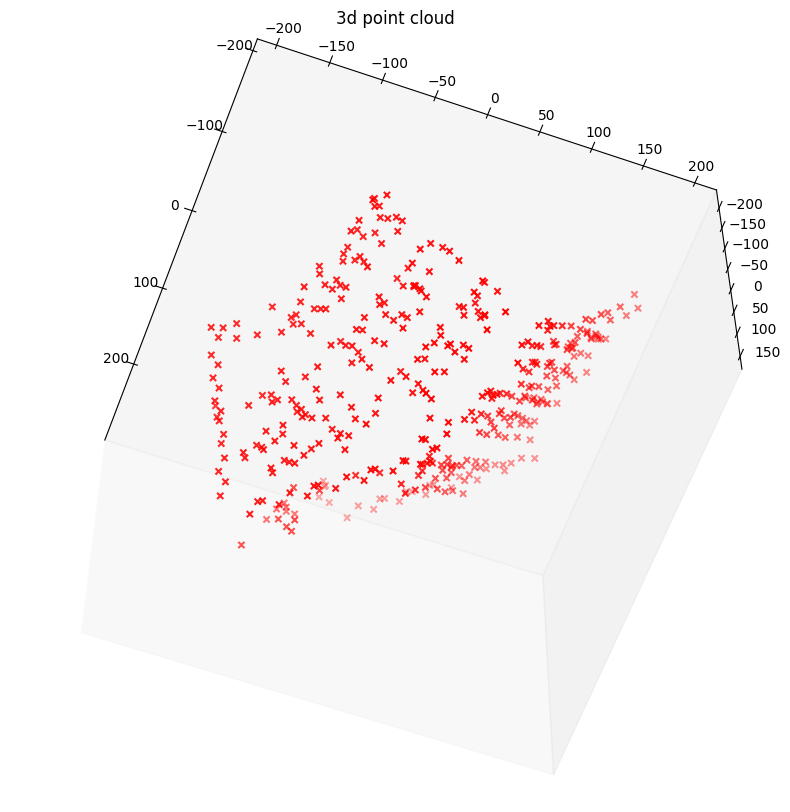

In [52]:
point_cloud_3d(scene_point , 120 ,20)

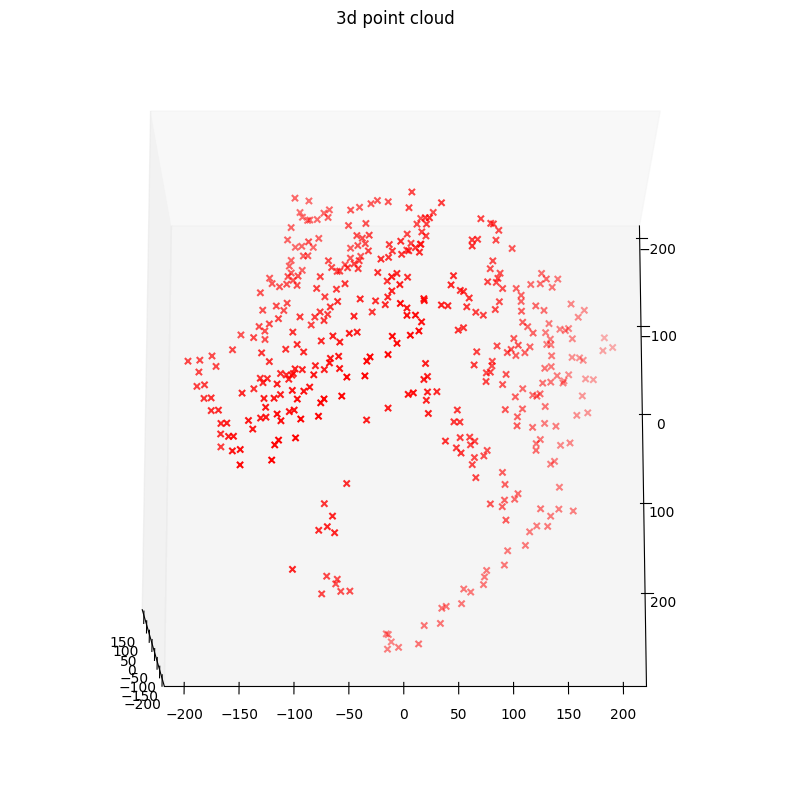

In [45]:
point_cloud_3d(scene_point , 75 ,0)

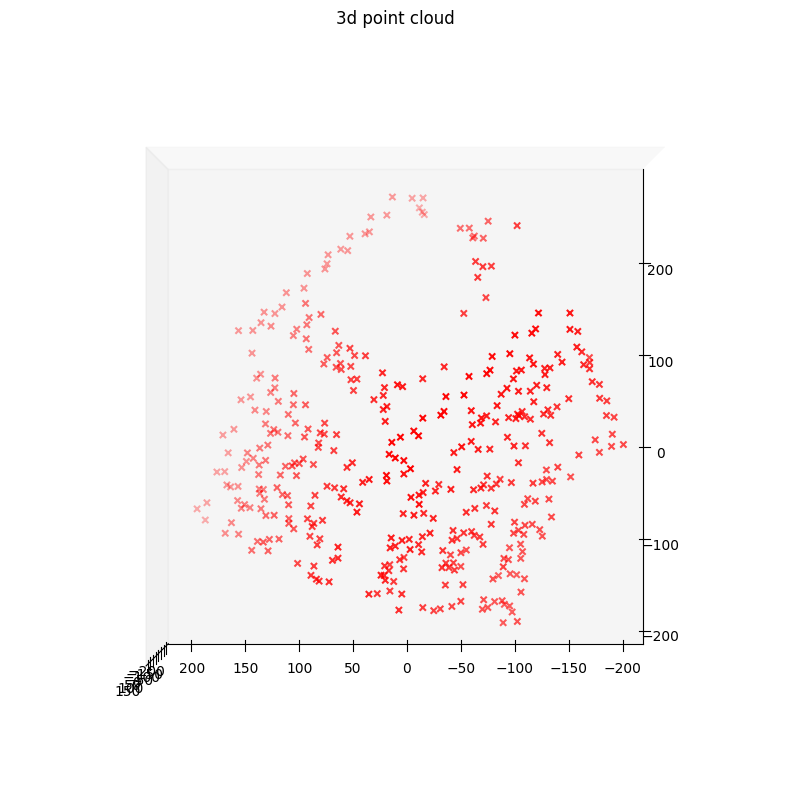

In [46]:
point_cloud_3d(scene_point, 90 ,180)

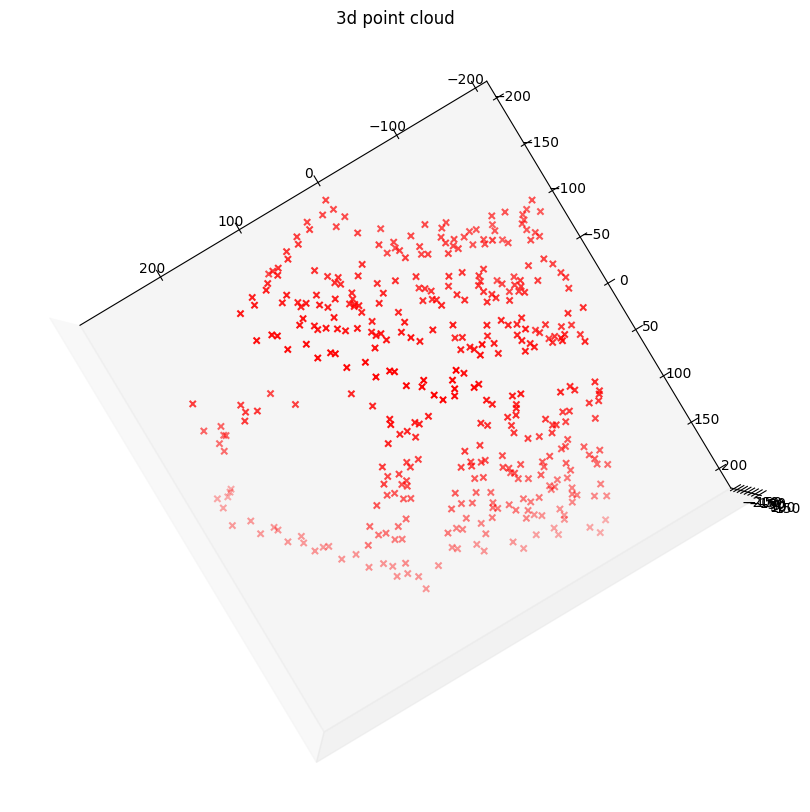

In [47]:
point_cloud_3d(scene_point, 90 , 60)

<Figure size 640x480 with 0 Axes>

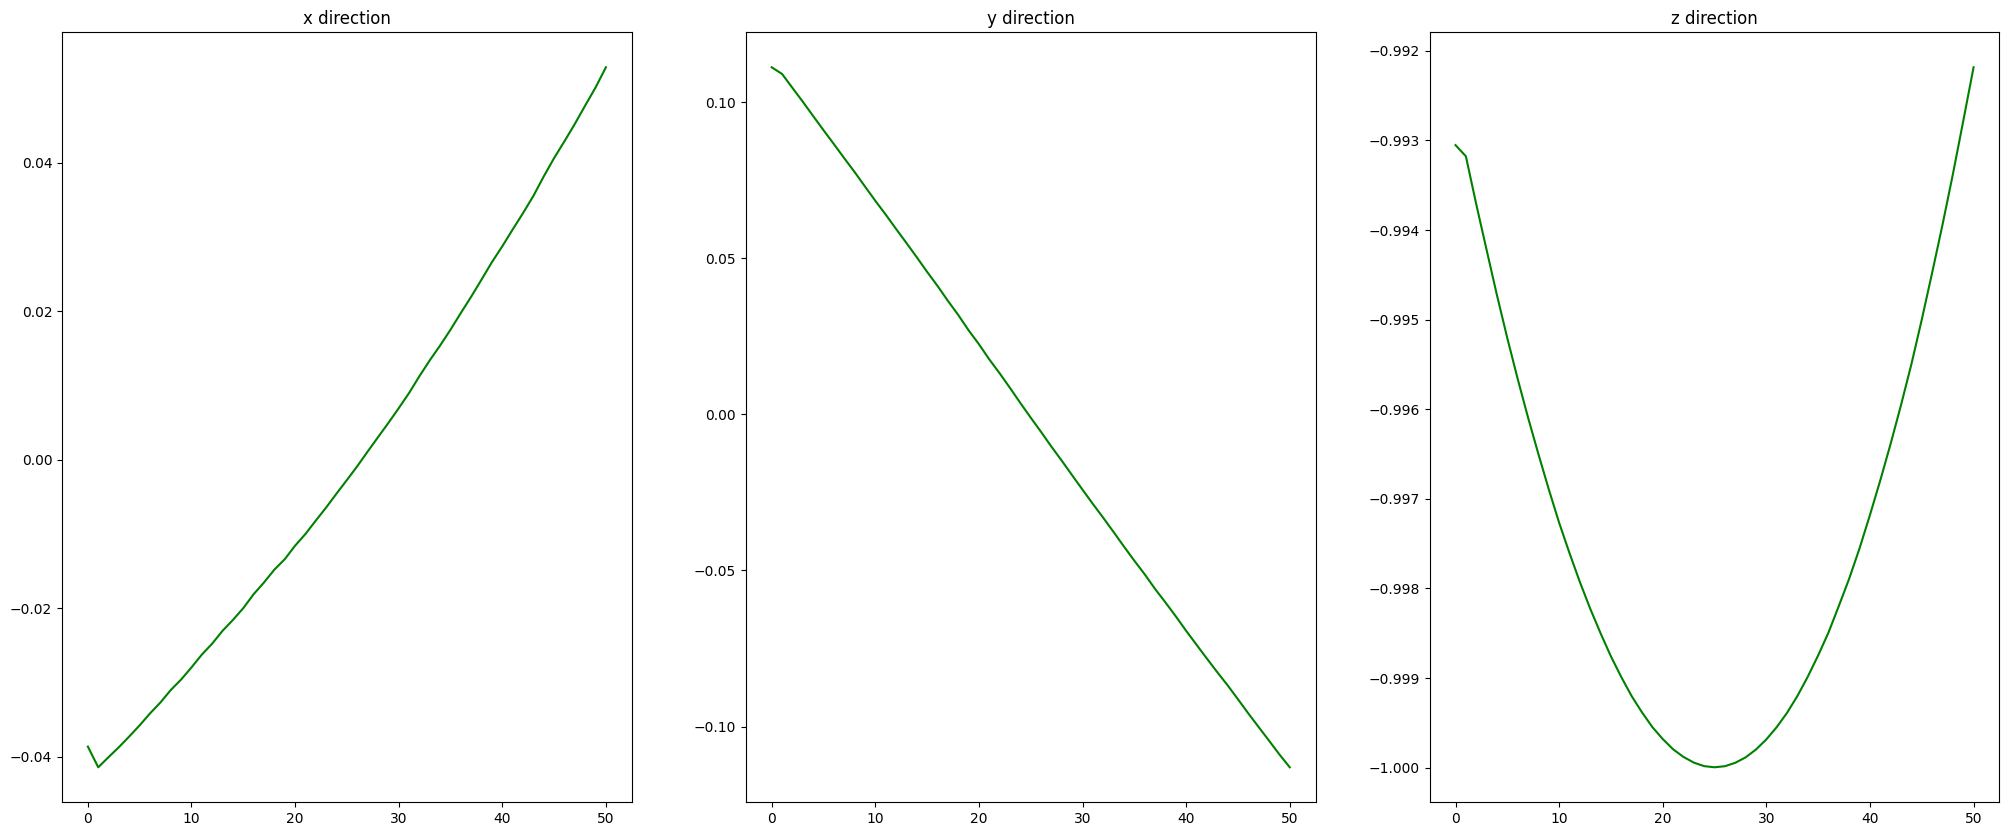

In [48]:
plot_cam(Cam_motion, frame_no)